### A/B Test

- A/B test for where half the emails were generic upsells to the product while the other half contained personalized messaging around individual usage of the site.

- Null Hypothesis (H₀): This hypothesis states that there is no difference between the control group (emails were generic upsells) and the treatment group (personalized messaging). It assumes that any observed difference is due to random chance rather than the effect of the treatment. In other words, the null hypothesis implies that the new version (treatment) does not have a significant impact compared to the control.

- Alternative Hypothesis (H₁): This hypothesis states that there is a significant difference between the control (emails were generic upsells) and treatment groups (personalized messaging). It suggests that the treatment (new version) does have an impact, either positive or negative, compared to the control.

In [4]:
# Import pandas into the environment
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Import marketing.csv 
marketing = pd.read_csv("marketing_cleaned.csv")


### Test allocation

- It is important to ensure users were allocated equally to the test and control groups.

In [6]:
marketing['variant'].value_counts()

variant
control            5091
personalization    4946
Name: count, dtype: int64

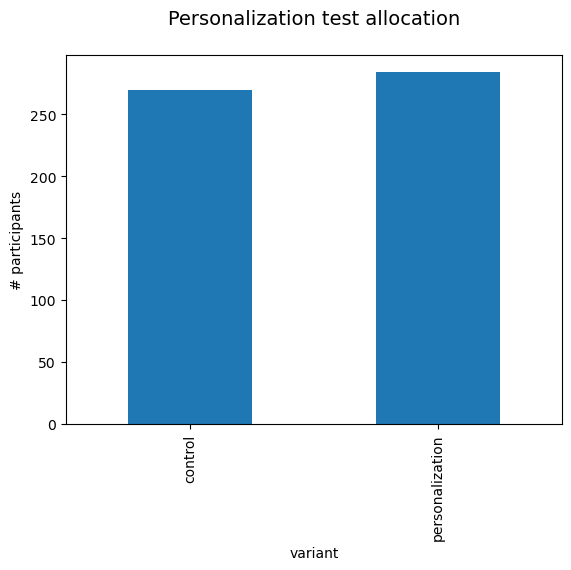

In [7]:
# Subset the DataFrame
email = marketing[marketing['marketing_channel']=='Email']

# Group the email DataFrame by variant 
alloc = email.groupby('variant')['user_id'].nunique()

# Plot a bar chart of the test allocation
alloc.plot(kind='bar')
plt.title('Personalization test allocation\n', size=14)
plt.ylabel('# participants')
plt.show()

### Comparing conversion rates

- Allocation is relatively even let's look at the conversion rate for the control and personalization. Since we chose conversion rate as our key metrics for this test, it is highly important that we evaluate whether or not conversion was higher in the personalization treatment compared with the control.

- Measuring the difference between the key metric in the control and the treatment is the most important part of evaluating the success of an A/B test.

In [9]:
# Group marketing by user_id and variant
subscribers = email.groupby(['user_id', 
                             'variant'])['converted'].max()

subscribers_df = pd.DataFrame(subscribers.unstack(level=1)) 

# Drop missing values from the control column
control = subscribers_df['control'].dropna()

# Drop missing values from the personalization column
personalization = subscribers_df['personalization'].dropna()

print('Control conversion rate:', np.mean(control))
print('Personalization conversion rate:', np.mean(personalization))

control = pd.to_numeric(control, errors='coerce')
personalization = pd.to_numeric(personalization, errors='coerce')

Control conversion rate: 0.2814814814814815
Personalization conversion rate: 0.3908450704225352


### Creating a lift function

- Lift can be calculated by calculating the difference between the treatment effect (or the mean) of the treatment compared to the treatment effect of the control divided by the treatment effect of the control. The formula for lift can be found below:
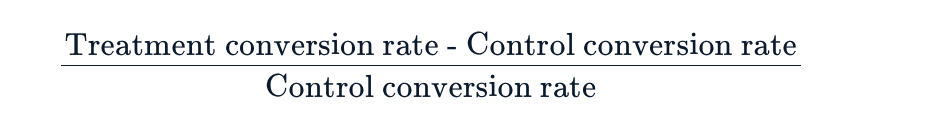

The result is the percent difference between the control and treatment.

In [11]:
def lift(a,b):
    # Calcuate the mean of a and b
    a_mean = np.mean(a)
    b_mean = np.mean(b)
    
    # Calculate the lift using a_mean and b_mean
    lift = (b_mean - a_mean)/a_mean
  
    return str(round(lift*100, 2)) + '%'
  
# Print lift() with control and personalization as inputs
print(lift(control, personalization))

38.85%


As you can see, there's a large lift, but are your results statistically significant? Lets find out it.

### Evaluating statistical significance

- The personalization variant outperformed the control, it's time to determine whether the result is statistically significant. Remember, statistical significance is vital to understanding whether a test showed a positive result by chance or if it is reflective of a true difference between the variants. This will enable marketing team to make an informed choice about whether to roll out the feature or not.

In [14]:
from scipy.stats import ttest_ind

ttest_ind(control, personalization)

TtestResult(statistic=-2.734329944750507, pvalue=0.0064514878446941815, df=552.0)

A p-value of 0.006 in the context of hypothesis testing indicates the probability that the observed results occurred by chance under the assumption that the null hypothesis is true. Here's what it implies:

- Low p-value: Since 0.006 is much lower than the common significance level (typically set at 0.05), it suggests that there is strong evidence against the null hypothesis.

- Statistical Significance: If your significance level is 0.05, a p-value of 0.006 means you would reject the null hypothesis. This indicates that the observed effect or difference between the control and treatment groups is statistically significant, and it's unlikely to have occurred by random chance.

- Confidence in Results: The lower the p-value, the more confident you can be that the treatment (or change) has a real effect. In this case, with a p-value of 0.006, there is only a 0.6% chance that the results are due to random variation, which strengthens the case for the effect being real.

### Building an A/B test segmenting function

- Personalization experiment is highly statistically significant. However, when running experiments, it is important to check how new features are affecting specific demographics. Sometimes features that are highly appealing to one group are less appealing to others.

In [17]:
def ab_segmentation(segment):
  
  # Build a for loop for each subsegment in marketing
  for subsegment in np.unique(marketing[segment].values):
      print(subsegment)
      
      # Limit marketing to email and subsegment
      email = marketing[(marketing['marketing_channel'] == 'Email') & (marketing[segment] == subsegment)]

      subscribers = email.groupby(['user_id', 'variant'])['converted'].max()
      subscribers = pd.DataFrame(subscribers.unstack(level=1)) 
      control = subscribers['control'].dropna()
      personalization = subscribers['personalization'].dropna()
      
      control = pd.to_numeric(control, errors='coerce')
      personalization = pd.to_numeric(personalization, errors='coerce')

      print('lift:', lift(control, personalization)) 
      print('t-statistic:', ttest_ind(control, personalization), '\n\n')

In [18]:
# Use ab_segmentation on language displayed
ab_segmentation('language_displayed')

Arabic
lift: 50.0%
t-statistic: TtestResult(statistic=-0.5773502691896255, pvalue=0.5795840000000001, df=8.0) 


English
lift: 39.0%
t-statistic: TtestResult(statistic=-2.2183598646203215, pvalue=0.026991701290720503, df=486.0) 


German
lift: -1.62%
t-statistic: TtestResult(statistic=0.19100834180787182, pvalue=0.8494394170062678, df=42.0) 


Spanish
lift: 166.67%
t-statistic: TtestResult(statistic=-2.3570226039551585, pvalue=0.04015671811047753, df=10.0) 




Often a treatment will not affect all people uniformly. Some people will love a particular marketing campaign while others hate it. As a marketing data scientist, it's your responsibility to enable your marketing stakeholders to target users according to their preferences.

These results represent the outcome of A/B tests conducted across different language groups (Arabic, English, German, and Spanish) with the following key metrics:

- **Lift**: This represents the percentage increase or decrease in the metric of interest (e.g., conversion rate, click-through rate) between the treatment group and the control group.

- **T-statistic**: This value comes from a t-test and indicates how many standard deviations the observed difference is from the null hypothesis of no difference. A more extreme t-statistic (either positive or negative) suggests a stronger effect.

- **P-value**: This value indicates the probability that the observed results occurred by chance if the null hypothesis is true. A p-value below a significance level (commonly 0.05) indicates that the result is statistically significant, leading to rejection of the null hypothesis.

Let's analyze each language group:

### 1. **Arabic**
   - **Lift**: 50.0% (indicating a 50% increase in the metric of interest)
   - **T-statistic**: -0.577
   - **P-value**: 0.580
   
   **Interpretation**: Despite a 50% lift, the p-value of 0.580 is much higher than 0.05, meaning the result is not statistically significant. The observed lift could be due to random chance, so you wouldn't reject the null hypothesis.

### 2. **English**
   - **Lift**: 39.0% (indicating a 39% increase)
   - **T-statistic**: -2.218
   - **P-value**: 0.027
   
   **Interpretation**: The 39% lift is statistically significant (p-value = 0.027, which is less than 0.05). The negative t-statistic suggests the observed effect is significant, and you would reject the null hypothesis, concluding that the treatment had a real impact.

### 3. **German**
   - **Lift**: -1.62% (indicating a slight decrease)
   - **T-statistic**: 0.191
   - **P-value**: 0.849
   
   **Interpretation**: The -1.62% lift is very small, and the p-value of 0.849 is far above the threshold of 0.05, indicating that the result is not statistically significant. You would not reject the null hypothesis.

### 4. **Spanish**
   - **Lift**: 166.67% (indicating a large increase)
   - **T-statistic**: -2.357
   - **P-value**: 0.040
   
   **Interpretation**: The large lift of 166.67% is statistically significant with a p-value of 0.040, which is just below 0.05. This suggests that the treatment had a significant effect, and you would reject the null hypothesis.

### Summary:
- **Statistically Significant Effects**: English (39.0% lift, p = 0.027) and Spanish (166.67% lift, p = 0.040).
- **Not Statistically Significant**: Arabic (50.0% lift, p = 0.580) and German (-1.62% lift, p = 0.849). 

In the English and Spanish groups, the treatments had a meaningful impact, whereas, in the Arabic and German groups, the changes might be attributed to random variation.

In [20]:
# Use ab_segmentation on age group
ab_segmentation('age_group')

0-18 years
lift: 121.4%
t-statistic: TtestResult(statistic=-2.966044912142212, pvalue=0.003872449439129706, df=89.0) 


19-24 years
lift: 106.24%
t-statistic: TtestResult(statistic=-3.0317943847866697, pvalue=0.0030623836114689195, df=105.0) 


24-30 years
lift: 161.19%
t-statistic: TtestResult(statistic=-3.861539544326876, pvalue=0.00018743381094867337, df=114.0) 


30-36 years
lift: -100.0%
t-statistic: TtestResult(statistic=3.185906464414798, pvalue=0.002323848743176535, df=58.0) 


36-45 years
lift: -85.23%
t-statistic: TtestResult(statistic=2.431790127931851, pvalue=0.017975686009788244, df=61.0) 


45-55 years
lift: -72.22%
t-statistic: TtestResult(statistic=2.0654991273179326, pvalue=0.04306233968820124, df=62.0) 


55+ years
lift: -100.0%
t-statistic: TtestResult(statistic=3.326565456420339, pvalue=0.0016358623456360468, df=51.0) 




Personalization was extremely effective for younger groups but less effective than the control for older groups. One explanation might be that younger users understand how their data might be used online and think personalization is cool because it gives them more insight into themselves while older people might feel that this is a violation of their privacy.